In [1]:
from dataset import svhn_dataset, toPIL
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from train import train_model
import model

# Load dataset

In [2]:
test_dataset = svhn_dataset("./data/SVHN/test",
                            transform=transforms.Compose(
                                [transforms.ToTensor(), 
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ])
                            )

train_dataset = svhn_dataset("./data/SVHN/train",
                             transform=transforms.Compose(
                                 [toPIL(),
                                  transforms.RandomChoice(
                                      [transforms.ColorJitter(brightness=[0.5,0.8],
                                                              contrast=[0.4,0.5],
                                                              saturation=[0,1]),
                                       transforms.RandomRotation(degrees=30)]),
                                  transforms.ColorJitter(hue=[-0.5,0.5]),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])
                             )

extra_dataset = svhn_dataset("./data/SVHN/extra",
                             transform=transforms.Compose(
                                 [transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])
                             )


loading data from ./data/SVHN/test
loading data from ./data/SVHN/train
loading data from ./data/SVHN/extra


In [3]:
train_loader = DataLoader(train_dataset, batch_size = 256, num_workers = 0, shuffle = True, drop_last = True)
validation_loader = DataLoader(test_dataset, batch_size = 256, num_workers = 0, shuffle = True, drop_last = True)
test_loader = DataLoader(extra_dataset, batch_size = 128, num_workers = 0, shuffle = True, drop_last = True)

In [4]:
print("training set has {} batches ".format(len(train_loader)))
print("validation set has {} batches ".format(len(validation_loader)))
print("test set has {} batches ".format(len(test_loader)))

training set has 130 batches 
validation set has 51 batches 
test set has 1580 batches 


## Plot a random image

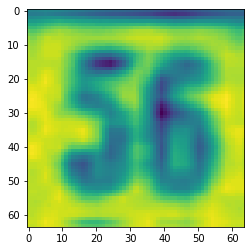

In [5]:
rnd = random.randint(0,10000)
image = train_dataset[rnd]["image"]
plt.figure()
plt.imshow(image.permute(1,2,0)[:,:,0])

# Train the model

In [6]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

scratch_model = model.vgg11_bn()

# Print the model we just instantiated
# print(scratch_model)

#params_to_update = scratch_model.parameters()
#print("Params to learn:")

#for name,param in scratch_model.named_parameters():
#    if param.requires_grad == True:
#        print("\t",name)

dataloaders_dict = {"train":train_loader,"val":validation_loader}
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.Adam(scratch_model.parameters(), lr=0.0001)
scratch_criterion = nn.CrossEntropyLoss()
best_model, scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, device, num_epochs=150)


Epoch 0/149
----------
train Loss: 1.1837 Acc: 0.5874
Predicciones tensor([10, 10, 10,  1,  4], device='cuda:0')
Real ....... tensor([10, 10, 10,  1,  2], device='cuda:0')
val Loss: 0.9654 Acc: 0.6595

Epoch 1/149
----------
train Loss: 1.0278 Acc: 0.6400


KeyboardInterrupt: 

## Save trained model

In [ ]:
PATH = './best_model.pth'
torch.save(best_model.state_dict(), PATH)

## Load model and test it with extra dataset

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = './best_model.pth'
model = vgg11_bn()
model = model.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()
correctos = 0.0
incorrectos = 0
total_imagenes = 0
for i, data in enumerate(test_loader,0):
    image = data["image"].to(device, dtype=torch.float)
    label = data["labels"].to(device, dtype=torch.long)
    totalbatch = len(image)
    total_imagenes += totalbatch
    out = model(image)
    _,preds = torch.max(out, 1)
    cor = preds.eq(label).sum()
    correctos += cor
    incorrectos += totalbatch*5 - (cor)
    
print(correctos, incorrectos, total_imagenes)
x = ((correctos.item())/(total_imagenes*5))*100
print("accuracy {}%".format(x))

## Plot Validation Accuracy vs. Number of Training Epochs

In [ ]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
shist = [h.cpu().numpy() for h in scratch_hist]
plt.plot(range(1,150+1),shist,label="Scratch")
plt.xticks(np.arange(0, 151, 15.0))
plt.legend()
plt.show()